## Подготовка к работе

Загрузим изображения и посмотрим на некоторые из них:

In [1]:
import os
import random
import copy
import time
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16_bn
from functools import reduce

In [2]:
images = []
lesions = []

for root, dirs, files in os.walk("./PH2 Dataset images"):
    if root.endswith("_Dermoscopic_Image"):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith("_lesion"):
        lesions.append(imread(os.path.join(root, files[0])))

size = (256, 256)
X = [
    resize(
        x,
        size,
        mode="constant",
        anti_aliasing=True,
    )
    for x in images
]
Y = [resize(y, size, mode="constant", anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f"Loaded {len(X)} images")

Loaded 200 images


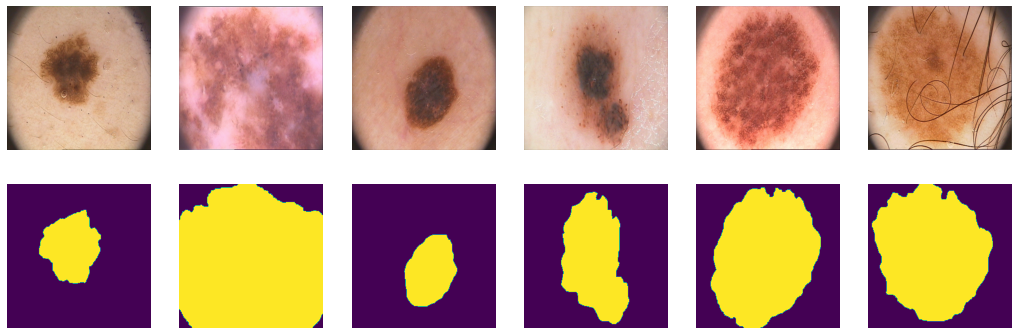

In [3]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i + 7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Определим выборки для обучения, валидации и теста:

In [4]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))


100 50 50


Создадим загрузчики данных, работающие с изменяющимися случайным образом изображениями (вертикальные/горизонтальные отражения):

In [5]:
class TensorTransformDataset(Dataset):
    """Датасет с аугментацией"""

    def __init__(self, X, Y, ids):
        super().__init__()
        self.X = torch.from_numpy(np.rollaxis(X[ids], 3, 1))
        self.Y = torch.from_numpy(Y[ids, np.newaxis])

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index]
        x, y = self.transform(x, y)
        return x, y

    def __len__(self):
        return self.X.size(0)

    def transform(self, x, y):
        # Random horizontal flipping
        if random.random() > 0.5:
            x = TF.hflip(x)
            y = TF.hflip(y)

        # Random vertical flipping
        if random.random() > 0.5:
            x = TF.vflip(x)
            y = TF.vflip(y)

        return x, y

train_dataset = TensorTransformDataset(X, Y, tr)
val_dataset = TensorTransformDataset(X, Y, val)
batch_size = 25
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
    batch_size=batch_size,
    shuffle=False,
)

dataloaders_dict = {"train": train_loader, "val": val_loader}

Визуально проверим работоспособность train_loader:

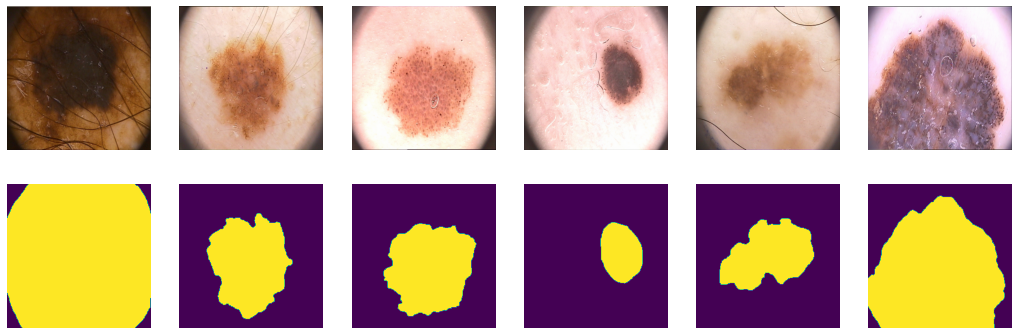

In [6]:
plt.figure(figsize=(18, 6))
batch = next(iter(train_loader))
for indx in range(len(batch[0])):
    plt.subplot(2, 6, indx + 1)
    plt.axis("off")
    plt.imshow(np.rollaxis(batch[0][indx].numpy(), 0, 3))

    plt.subplot(2, 6, indx + 7)
    plt.axis("off")
    plt.imshow(np.squeeze(batch[1][indx].numpy(), axis=0))
    if 5 == indx:
        break
plt.show()

Выглядит правильно. Обучаться предпочтительнее на GPU:

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## SegNet + IoU + BCEWithLogitsLoss

Кодирующая часть сети полностью идентична VGG16, поэтому используем уже обученные на ImageNet блоки оттуда, а декодер сделаем вручную:

In [8]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


# https://arxiv.org/pdf/1511.00561.pdf
class SegNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SegNet, self).__init__()
        features = list(vgg16_bn(pretrained=True).features.children())

        """ en0 structure
        Conv2d:         (batch_size, 3, 256, 256) -> (batch_size, 64, 256, 256)
        BatchNorm2d + ReLU
        Conv2d:         (batch_size, 64, 256, 256) -> (batch_size, 64, 256, 256)
        BatchNorm2d + ReLU
        MaxPool2d:      (batch_size, 64, 256, 256) -> (batch_size, 64, 128, 128) + indexes
        """
        features[6].return_indices = True
        self.en0 = nn.Sequential(*features[0:7])

        """ en1: (batch_size, 64, 128, 128) -> (batch_size, 128, 64, 64) + indexes
        Conv2d + BatchNorm2d + ReLU
        Conv2d + BatchNorm2d + ReLU
        MaxPool2d
        """
        features[13].return_indices = True
        self.en1 = nn.Sequential(*features[7:14])

        """ en2: (batch_size, 128, 64, 64) -> (batch_size, 256, 32, 32) + indexes
        Conv2d + BatchNorm2d + ReLU
        Conv2d + BatchNorm2d + ReLU
        Conv2d + BatchNorm2d + ReLU
        MaxPool2d
        """
        features[23].return_indices = True
        self.en2 = nn.Sequential(*features[14:24])

        """ en3: (batch_size, 256, 32, 32) -> (batch_size, 512, 16, 16) + indexes
        Conv2d + BatchNorm2d + ReLU
        Conv2d + BatchNorm2d + ReLU
        Conv2d + BatchNorm2d + ReLU
        MaxPool2d
        """
        features[33].return_indices = True
        self.en3 = nn.Sequential(*features[24:34])

        """ en4: (batch_size, 512, 16, 16) -> (batch_size, 512, 8, 8) + indexes
        Conv2d + BatchNorm2d + ReLU
        Conv2d + BatchNorm2d + ReLU
        Conv2d + BatchNorm2d + ReLU
        MaxPool2d
        """
        features[43].return_indices = True
        self.en4 = nn.Sequential(*features[34:])

        self.dec4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.dec0 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_classes),
            nn.ReLU(inplace=True),
        )

        initialize_weights(self.dec4, self.dec3, self.dec2, self.dec1, self.dec0)

    def forward(self, x):
        # encoder
        e0, ind0 = self.en0(x)
        e1, ind1 = self.en1(e0)
        e2, ind2 = self.en2(e1)
        e3, ind3 = self.en3(e2)
        e4, ind4 = self.en4(e3)

        # decoder
        d4 = F.max_unpool2d(e4, ind4, kernel_size=2, stride=2, output_size=e3.size())
        d4 = self.dec4(d4)
        d3 = F.max_unpool2d(d4, ind3, kernel_size=2, stride=2, output_size=e2.size())
        d3 = self.dec3(d3)
        d2 = F.max_unpool2d(d3, ind2, kernel_size=2, stride=2, output_size=e1.size())
        d2 = self.dec2(d2)
        d1 = F.max_unpool2d(d2, ind1, kernel_size=2, stride=2, output_size=e0.size())
        d1 = self.dec1(d1)
        d0 = F.max_unpool2d(d1, ind0, kernel_size=2, stride=2, output_size=x.size())
        d0 = self.dec0(d0)

        return d0

В качестве критерия, характеризующего степень сходства изображений, будем использовать IoU (Intersection over Union):

In [9]:
SMOOTH = 1e-8


def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    """Преобразования над outputs и labels:
    1) Выход модели -> вероятности (сигмоида)
    2) (batch_size, 1, H, W) -> (batch_size, H, W)
    3) Приведение типа к torch.uint8 (byte)
    """
    outputs = (torch.sigmoid(outputs) > 0.5)
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()

    """
    Для каждой пары пикселей из output и labels применить логическое И, затем посчитать кол-во
    истинных выражений
    """
    intersection = (outputs & labels).float().sum((1, 2))

    """
    Аналогично предыдущему, только использовать логическое ИЛИ
    """
    union = (outputs | labels).float().sum((1, 2))

    """
    Вычислить IoU, избегая 0/0
    """
    iou = (intersection + SMOOTH) / (union + SMOOTH)

    """
    Мы хотим, чтобы IoU меньше порогового значения (=0.5) считалось 0, т.е. будто изображения
    абсолютно разные. Плюс хорошо бы округлить числа до десятых. Для этих целей проделаем следующее:
    1) Сместим IoU шкалу [0, 1] -> [-1, 1]
    2) Умножим IoU на 10, все элементы < 0 сделаем = 0
    3) Округлим до целых
    4) Разделим на 10
    """
    thresholded = (
        torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    )  # This is equal to comparing with thresolds

    return thresholded

Сделаем свою версию функционала ошибки, совмещающую Binary Cross Entropy и Sigmoid:

In [10]:
def bce_loss(output, target):
    N = output.size(0)
    mean = 0
    for index in range(N):
        y_p = output[index]
        y_r = target[index]
        loss = (1 - y_r) * y_p + torch.log(1 + torch.exp(-y_p))
        mean += torch.mean(loss) / N
    return mean

Можно проверить, что реализация из pytorch работает схожим образом:

In [11]:
batch1 = next(iter(train_loader))
torch_bce_loss = nn.BCEWithLogitsLoss()
print(
    "Single image, bce_loss: ",
    bce_loss(batch[1][0], batch[1][0]).item(),
    " torch_bce_loss: ",
    torch_bce_loss(batch[1][0], batch[1][0]).item(),
)
print(
    "Entire batch, bce_loss: ",
    bce_loss(batch[1], batch1[1]).item(),
    " torch_bce_loss: ",
    torch_bce_loss(batch[1], batch1[1]).item(),
)

Single image, bce_loss:  0.32957324385643005  torch_bce_loss:  0.32957324385643005
Entire batch, bce_loss:  0.7273590564727783  torch_bce_loss:  0.7273589968681335


Определим алгоритм обучения модели:

In [12]:
def train_model(
    model, dataloaders, criterion, metric, optimizer, scheduler, num_epochs=30
):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(
            "Epoch {}/{} (lr={:.2E})".format(
                epoch, num_epochs - 1, optimizer.param_groups[0]["lr"]
            )
        )
        print("-" * 25)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1, keepdim=True)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_corrects += metric(outputs, labels).mean().item()

            # Loss усредняется по кол-ву батчей
            epoch_loss = running_loss / len(dataloaders[phase])
            # Усредняется (по числу батчей) среднее IoU всех картинок в каждом батче
            epoch_acc = running_corrects / len(dataloaders[phase])
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss = epoch_loss
                train_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc

        scheduler.step()
        history.append((train_loss, train_acc, val_loss, val_acc))
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history

Далее сделаем несколько вспомогательных функций, одна из
которых делает сегментацию изображений в батче, а другая
оценивает качество модели в целом на соотв. загрузчике данных:

In [13]:
def generate_segmented(model, X_batch):
    with torch.no_grad():
        inputs = X_batch.to(device)
        model.eval()
        outputs = model(inputs)

    return outputs


def score_model(model, metric, data):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = generate_segmented(model, X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores / len(data)

Сгенерируем экземпляр нашей модели; посмотрим на параметры, что будут меняться в процессе обучения:

In [14]:
model = SegNet().to(device)

params_to_update = model.parameters()
print("Params to learn:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print("\t", name)

Params to learn:
	 en0.0.weight
	 en0.0.bias
	 en0.1.weight
	 en0.1.bias
	 en0.3.weight
	 en0.3.bias
	 en0.4.weight
	 en0.4.bias
	 en1.0.weight
	 en1.0.bias
	 en1.1.weight
	 en1.1.bias
	 en1.3.weight
	 en1.3.bias
	 en1.4.weight
	 en1.4.bias
	 en2.0.weight
	 en2.0.bias
	 en2.1.weight
	 en2.1.bias
	 en2.3.weight
	 en2.3.bias
	 en2.4.weight
	 en2.4.bias
	 en2.6.weight
	 en2.6.bias
	 en2.7.weight
	 en2.7.bias
	 en3.0.weight
	 en3.0.bias
	 en3.1.weight
	 en3.1.bias
	 en3.3.weight
	 en3.3.bias
	 en3.4.weight
	 en3.4.bias
	 en3.6.weight
	 en3.6.bias
	 en3.7.weight
	 en3.7.bias
	 en4.0.weight
	 en4.0.bias
	 en4.1.weight
	 en4.1.bias
	 en4.3.weight
	 en4.3.bias
	 en4.4.weight
	 en4.4.bias
	 en4.6.weight
	 en4.6.bias
	 en4.7.weight
	 en4.7.bias
	 dec4.0.weight
	 dec4.0.bias
	 dec4.1.weight
	 dec4.1.bias
	 dec4.3.weight
	 dec4.3.bias
	 dec4.4.weight
	 dec4.4.bias
	 dec4.6.weight
	 dec4.6.bias
	 dec4.7.weight
	 dec4.7.bias
	 dec3.0.weight
	 dec3.0.bias
	 dec3.1.weight
	 dec3.1.bias
	 dec3.3.weight

Выберем оптимизатор и планировщик (меняющий скорость обучения), после чего запустим обучение:

In [15]:
optimizer = torch.optim.AdamW(params_to_update, lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
model, hist = train_model(
    model, dataloaders_dict, bce_loss, iou_pytorch, optimizer, scheduler
)

Epoch 0/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6935 Acc: 0.0340
val Loss: 0.7121 Acc: 0.0000

Epoch 1/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6563 Acc: 0.0620
val Loss: 0.6931 Acc: 0.0000

Epoch 2/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6574 Acc: 0.1830
val Loss: 0.7438 Acc: 0.0300

Epoch 3/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6214 Acc: 0.2730
val Loss: 0.6731 Acc: 0.0580

Epoch 4/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6014 Acc: 0.4160
val Loss: 0.6785 Acc: 0.0100

Epoch 5/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5868 Acc: 0.4550
val Loss: 0.6411 Acc: 0.2360

Epoch 6/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5876 Acc: 0.4310
val Loss: 0.5793 Acc: 0.4380

Epoch 7/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5801 Acc: 0.5410
val Loss: 0.5761 Acc: 0.5240

Epoch 8/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5786 Acc: 0.5710
val Loss: 0.5556 Acc: 

### Результаты

Посмотрим как менялось качество модели и значения функционала ошибки в зависимости от эпох:

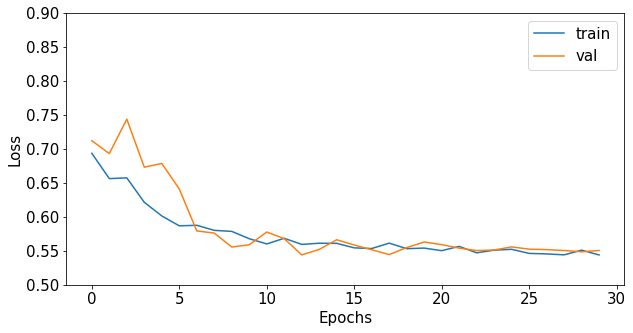

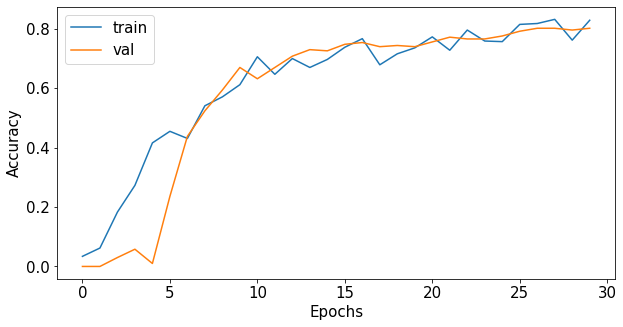

In [16]:
loss, acc, val_loss, val_acc = zip(*hist)

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.ylim([0.5, 0.9])
plt.plot(loss, label="train")
plt.plot(val_loss, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.plot(acc, label="train")
plt.plot(val_acc, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


Оценим качество модели на тестовой выборке:

In [17]:
score = score_model(model, iou_pytorch, test_loader)
print("Model score: ", score)

Model score:  0.8059999644756317


Теперь графически продемонстрируем результаты работы модели на нескольких картинках из той же выборки:

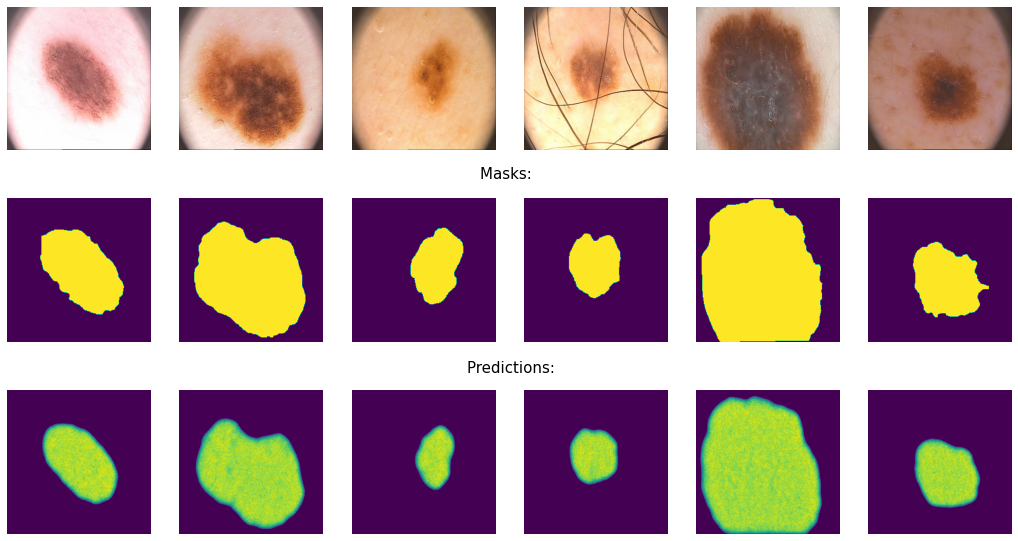

In [18]:
fig = plt.figure(figsize=(18, 10))
batch = next(iter(test_loader))
batch_pred = torch.sigmoid(generate_segmented(model, batch[0]).cpu())
for indx in range(len(batch[0])):
    plt.subplot(3, 6, indx + 1)
    plt.axis("off")
    plt.imshow(np.rollaxis(batch[0][indx].numpy(), 0, 3))

    plt.subplot(3, 6, indx + 7)
    plt.axis("off")
    plt.imshow(np.squeeze(batch[1][indx].numpy(), axis=0))

    plt.subplot(3, 6, indx + 13)
    plt.axis("off")
    plt.imshow(np.squeeze(batch_pred[indx].numpy(), axis=0))

    if 5 == indx:
        break
plt.text(0.49, 0.63, "Masks: ", fontsize=15, transform=fig.transFigure)
plt.text(0.48, 0.36, "Predictions: ", fontsize=15, transform=fig.transFigure)
plt.show()


Сохраним всю статистику данной модели для использования в дальнейшем:

In [19]:
model_stats = {}
model_stats['SegNet_IoU_BCEWithLogitsLoss'] = (score, hist)

Остальные модели проверим уже без каких-либо подробных комментариев, оставив все выводы для заключения.

## SegNet + IoU + DiceLoss

In [20]:
"""
# Реализация из статьи https://arxiv.org/pdf/1606.04797.pdf
def dice_loss(output, target):

    output = output.squeeze(1)
    output = torch.sigmoid(output)
    target = target.squeeze(1)

    intersection = 2 * (output * target).sum((1, 2))
    union = (output.square() + target.square()).sum((1, 2))
    loss = 1 - (intersection + SMOOTH) / (union + SMOOTH)

    return loss.mean()
"""
None

In [21]:
def dice_loss(output, target):

    output = output.squeeze(1)
    output = torch.sigmoid(output)
    target = target.squeeze(1)

    intersection = 2 * output * target
    union = output + target
    loss = 1 - ((intersection + SMOOTH) / (union + SMOOTH)).sum((1, 2))/65536

    return loss.mean()

In [22]:
model_dice = SegNet().to(device)

optimizer = torch.optim.AdamW(model_dice.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
model_dice, hist = train_model(
    model_dice, dataloaders_dict, dice_loss, iou_pytorch, optimizer, scheduler
)

Epoch 0/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7416 Acc: 0.1310
val Loss: 0.7774 Acc: 0.0000

Epoch 1/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7187 Acc: 0.3190
val Loss: 0.7717 Acc: 0.0380

Epoch 2/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7072 Acc: 0.5840
val Loss: 0.7736 Acc: 0.0080

Epoch 3/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7046 Acc: 0.6290
val Loss: 0.7506 Acc: 0.1940

Epoch 4/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7048 Acc: 0.6460
val Loss: 0.7046 Acc: 0.3740

Epoch 5/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7050 Acc: 0.6170
val Loss: 0.6886 Acc: 0.4800

Epoch 6/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7037 Acc: 0.6720
val Loss: 0.7025 Acc: 0.5200

Epoch 7/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7021 Acc: 0.6640
val Loss: 0.6929 Acc: 0.5320

Epoch 8/29 (lr=1.00E-03)
-------------------------
train Loss: 0.7020 Acc: 0.7300
val Loss: 0.6953 Acc: 

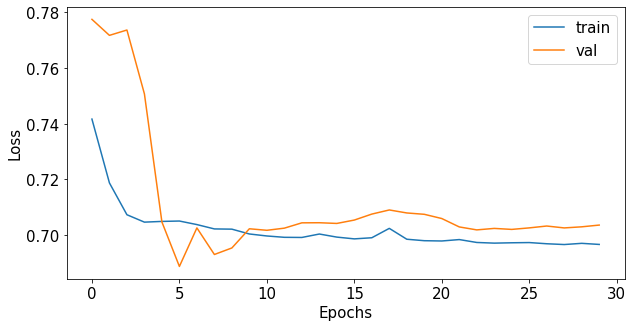

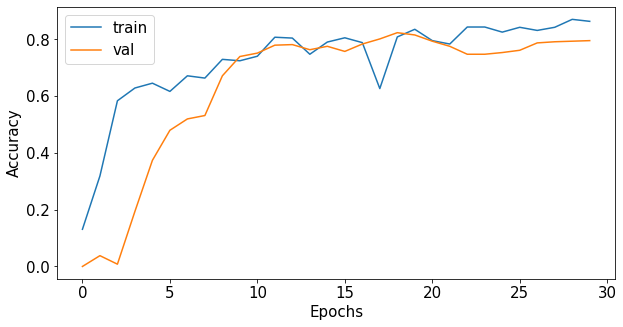

In [23]:
loss, acc, val_loss, val_acc = zip(*hist)

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.plot(loss, label="train")
plt.plot(val_loss, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.plot(acc, label="train")
plt.plot(val_acc, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [24]:
score = score_model(model_dice, iou_pytorch, test_loader)
model_stats['SegNet_IoU_DiceLoss'] = (score, hist)
print("Model score: ", score)

Model score:  0.8059999942779541


## SegNet + IoU + FocalLoss

In [25]:
# https://arxiv.org/pdf/1708.02002.pdf
def focal_loss(output, target, alpha = 1, gamma = 2):

    # BCEWithLogits
    N = output.size(0)
    mean = 0
    for index in range(N):
        y_p = output[index]
        y_r = target[index]
        loss = (1 - y_r) * y_p + torch.log(1 + torch.exp(-y_p))
        mean += loss / N
    
    # mean фактически является -ln(probability) каждого пикселя соответствовать пикселям из target, тогда
    prob = torch.exp(-mean)

    """
    alpha - гиперпараметр
    Также можно сделать равным обратной частоте классов, но эффективность сомнительна

    gamma - фокусирующий параметр
    Когда модель выдает маленькую вероятность, величина ошибки почти без изменений
    Когда модель уверена в ответе и вероятность большая, величина ошибки занижается
    Таким образом легкие для классификации изображения вносят меньший вклад
    """ 
    f_loss = alpha * (1-prob)**gamma * mean

    return f_loss.mean()

In [26]:
model_focal = SegNet().to(device)

optimizer = torch.optim.AdamW(model_focal.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
model_focal, hist = train_model(
    model_focal, dataloaders_dict, focal_loss, iou_pytorch, optimizer, scheduler
)

Epoch 0/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1737 Acc: 0.0650
val Loss: 1.9010 Acc: 0.0460

Epoch 1/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1593 Acc: 0.0550
val Loss: 0.1733 Acc: 0.0000

Epoch 2/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1513 Acc: 0.0720
val Loss: 0.1733 Acc: 0.0000

Epoch 3/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1374 Acc: 0.2380
val Loss: 0.1570 Acc: 0.0760

Epoch 4/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1263 Acc: 0.4260
val Loss: 0.1612 Acc: 0.2640

Epoch 5/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1329 Acc: 0.2980
val Loss: 0.6110 Acc: 0.1840

Epoch 6/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1299 Acc: 0.3110
val Loss: 0.1713 Acc: 0.3340

Epoch 7/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1195 Acc: 0.4940
val Loss: 0.1351 Acc: 0.5080

Epoch 8/29 (lr=1.00E-03)
-------------------------
train Loss: 0.1193 Acc: 0.5480
val Loss: 0.1394 Acc: 

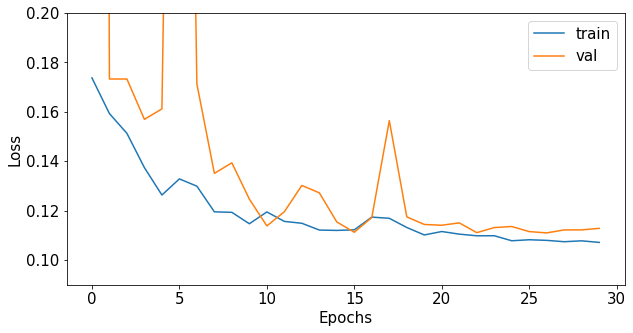

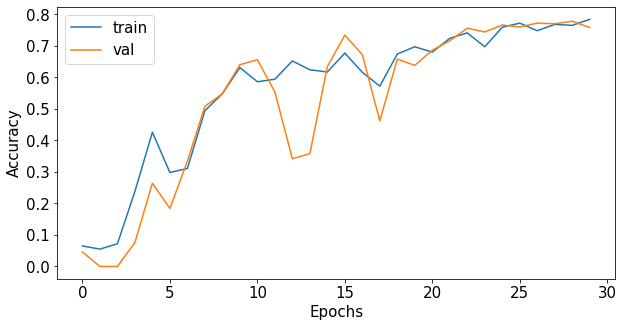

In [27]:
loss, acc, val_loss, val_acc = zip(*hist)

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.ylim([0.09, 0.2])
plt.plot(loss, label="train")
plt.plot(val_loss, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.plot(acc, label="train")
plt.plot(val_acc, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [28]:
score = score_model(model_focal, iou_pytorch, test_loader)
model_stats['SegNet_IoU_FocalLoss'] = (score, hist)
print("Model score: ", score)

Model score:  0.7579999566078186


## SegNet + IoU + TopoLoss

Кратко о том, что здесь вообще происходит:


1.   Для вероятностей предсказанных моделью и истинного ответа (маски) расчитываются диаграммы персистентности, несущие информацио о числе связных подмножеств пространства и числе разрезов в нем.
2.   Среди множества всех биекций между точками этих диаграмм определенным образом выбирается оптимальная, а затем рассчитывается расстояние между образами и прообразами. Точки, соответствующие малой временной разнице между рождением и смертью считаются шумом. Как раз из-за сложности выбора хорошей биекции TopoLoss лучше применять лишь на завершающих этапах обучения (но здесь этого делаться не будет из соображений сравнения, все остальные модели обучались от начала до конца на одной и той же функции потерь)
3.   Каждый шаг градиантного спуска стремится уменьшить расстояние между образами и прообразами, тем самым улучшая топологическое сходство между предсказаниями и масками.


In [29]:
!git clone https://github.com/HuXiaoling/TopoLoss
%cd /content/TopoLoss/Code/cPers/cPers
!g++ -O3 -w -shared -fPIC -std=c++11 -I ../ -I pybind11-stable/include `python3-config --cflags --ldflags --libs` PersistencePython.cpp Debugging.cpp PersistenceIO.cpp -o /content/PersistencePython.so
%cd /content
!rm -rf ./TopoLoss
!pip install gudhi

Cloning into 'TopoLoss'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (352/352), done.
remote: Total 423 (delta 98), reused 354 (delta 55), pack-reused 0
Receiving objects: 100% (423/423), 4.55 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/TopoLoss/Code/cPers/cPers
/content


In [30]:
# https://arxiv.org/pdf/1906.05404.pdf
from PersistencePython import cubePers
import gudhi


def compute_persistence_2DImg_1DHom_lh(f):
    """
    Получает диаграмму персистентности для предсказаний модели
    Сохраняет лишь информацию о точках, связанных с числом разрезов пространства без увеличения связности (1d)
    """
    assert len(f.shape) == 2
    dim = 2
    padwidth = 2
    padvalue = torch.tensor(0.0)
    f_padded = np.pad(
        f.cpu().detach().numpy(),
        padwidth,
        "constant",
        constant_values=padvalue.cpu().detach().numpy(),
    )
    persistence_result = cubePers(
        np.reshape(f_padded, f_padded.size).tolist(), list(f_padded.shape), 0.001
    )
    persistence_result_filtered = np.array(
        list(filter(lambda x: x[0] == 1, persistence_result))
    )
    dgm = persistence_result_filtered[:, 1:3]
    birth_cp_list = persistence_result_filtered[:, 4 : 4 + dim]
    death_cp_list = persistence_result_filtered[:, 4 + dim :]
    birth_cp_list = birth_cp_list - padwidth
    death_cp_list = death_cp_list - padwidth

    return dgm, birth_cp_list, death_cp_list


def compute_persistence_2DImg_1DHom_gt(f):
    """
    Получает диаграмму персистентности для истинного ответа
    Сохраняет лишь информацию о точках, связанных с числом разрезов пространства без увеличения связности (1d)
    """
    assert len(f.shape) == 2
    dim = 2
    padwidth = 2
    padvalue = f.min()
    f_padded = np.pad(
        f.cpu().numpy(), padwidth, "constant", constant_values=padvalue.cpu().numpy()
    )
    persistence_result = cubePers(
        np.reshape(f_padded, f_padded.size).tolist(), list(f_padded.shape), 0.001
    )
    persistence_result_filtered = np.array(
        list(filter(lambda x: x[0] == 1, persistence_result))
    )
    dgm = persistence_result_filtered[:, 1:3]

    birth_cp_list = persistence_result_filtered[:, 4 : 4 + dim]
    death_cp_list = persistence_result_filtered[:, 4 + dim :]
    birth_cp_list = birth_cp_list - padwidth
    death_cp_list = death_cp_list - padwidth

    return dgm, birth_cp_list, death_cp_list


def compute_dgm_force(lh_dgm, gt_dgm):
    # get persistence list from both diagrams
    lh_pers = lh_dgm[:, 1] - lh_dgm[:, 0]
    gt_pers = gt_dgm[:, 1] - gt_dgm[:, 0]

    assert lh_pers.size > gt_pers.size
    tmp = gt_pers > 0.999

    assert tmp.sum() == gt_pers.size

    gt_n_holes = gt_pers.size
    tmp = lh_pers > 0.999
    if np.sum(tmp) >= 1:
        lh_n_holes_perfect = tmp.sum()
        idx_holes_perfect = np.argpartition(lh_pers, -lh_n_holes_perfect)[
            -lh_n_holes_perfect:
        ]
    else:
        idx_holes_perfect = np.where(lh_pers == lh_pers.max())[0]
    idx_holes_to_fix_or_perfect = np.argpartition(lh_pers, -gt_n_holes)[-gt_n_holes:]
    idx_holes_to_fix = list(set(idx_holes_to_fix_or_perfect) - set(idx_holes_perfect))
    idx_holes_to_remove = list(
        set(range(lh_pers.size)) - set(idx_holes_to_fix_or_perfect)
    )
    pers_thd = 0.03
    idx_valid = np.where(lh_pers > pers_thd)[0]
    idx_holes_to_remove = list(set(idx_holes_to_remove).intersection(set(idx_valid)))
    force_list = np.zeros(lh_dgm.shape)
    force_list[idx_holes_to_fix, 0] = 0 - lh_dgm[idx_holes_to_fix, 0]
    force_list[idx_holes_to_fix, 1] = 1 - lh_dgm[idx_holes_to_fix, 1]
    force_list[idx_holes_to_remove, 0] = lh_pers[idx_holes_to_remove] / math.sqrt(2.0)
    force_list[idx_holes_to_remove, 1] = -lh_pers[idx_holes_to_remove] / math.sqrt(2.0)

    return force_list, idx_holes_to_fix, idx_holes_to_remove


def draw_pers_dgms(lh_dgm, gt_dgm):
    """
    Рисует две диаграммы персистентности на одной картинке
    """
    plt.figure("Diagrams")
    plt.rcParams.update({"font.size": 10})
    plt.clf()
    plt.plot([0, 1], [0, 1], "k-")

    force_list, idx_holes_to_fix, idx_holes_to_remove = compute_dgm_force(
        lh_dgm, gt_dgm
    )

    plt.scatter([lh_dgm[:, 0]], [lh_dgm[:, 1]], color="green", label="Likelihood")

    """
    for idx in idx_holes_to_fix:
        plt.arrow(
            lh_dgm[idx, 0],
            lh_dgm[idx, 1],
            force_list[idx, 0],
            force_list[idx, 1],
            head_width=0.02,
            head_length=0.03,
            color="r",
        )

    for idx in idx_holes_to_remove:
        plt.arrow(
            lh_dgm[idx, 0],
            lh_dgm[idx, 1],
            force_list[idx, 0],
            force_list[idx, 1],
            head_width=0.02,
            head_length=0.03,
            color="c",
        )
    """
    # add small noise to gt persistent dots, so they don't overlap too much
    gt_dgm = gt_dgm + 0.05 * (np.random.random_sample(gt_dgm.shape) - 0.5)

    plt.scatter(
        [gt_dgm[:, 0]], [gt_dgm[:, 1]], color="blue", label="Groundtruth jittered"
    )
    plt.ylabel("Death Time")
    plt.xlabel("Birth Time")
    plt.title("Persistence Diagrams")
    plt.axis("equal")
    plt.legend()


def compute_persistence_diagram(matrix, min_pers=0, i=5):
    dims = matrix.shape
    size = reduce(lambda x, y: x * y, dims, 1)
    cubical_complex = gudhi.CubicalComplex(
        dimensions=dims, top_dimensional_cells=np.reshape(matrix.T, size)
    )
    if i == 5:
        pd = cubical_complex.persistence(
            homology_coeff_field=2, min_persistence=min_pers
        )
        return np.array(map(lambda row: [row[1][0], row[1][1]], pd))
    else:
        pd = cubical_complex.persistence(
            homology_coeff_field=2, min_persistence=min_pers
        )
        pd = cubical_complex.persistence_intervals_in_dimension(i)
        return np.array(list(map(lambda row: [row[0], row[1]], pd)))


def betti_number(imagely):
    imagely = imagely.detach().cpu().clone().numpy()
    width, height = imagely.shape
    imagely[width - 1, :] = 0
    imagely[:, height - 1] = 0
    imagely[0, :] = 0
    imagely[:, 0] = 0
    temp = compute_persistence_diagram(imagely, i=1)
    betti_number = len(temp)
    return betti_number


def getPers(likelihoods, groundtruth):
    pers_thd_lh = 0.03
    pers_thd_gt = 0.03
    (
        pd_lh_all,
        bcp_lh_all,
        dcp_lh_all,
        pd_gt_all,
        bcp_gt_all,
        dcp_gt_all,
        lh_pers_all,
        lh_pers_valid_all,
        gt_pers_all,
        gt_pers_valid_all,
    ) = ([] for i in range(10))
    for likelihood in likelihoods:
        if torch.min(likelihood) == 1:
            continue
        if torch.max(likelihood) == 0:
            continue
        pd_lh, bcp_lh, dcp_lh = compute_persistence_2DImg_1DHom_lh(likelihood)

        if pd_lh.shape[0] > 0:
            lh_pers = pd_lh[:, 1] - pd_lh[:, 0]
            lh_pers_valid = lh_pers[np.where(lh_pers > pers_thd_lh)]
        else:
            lh_pers = np.array([])
            lh_pers_valid = np.array([])

        pd_gt, bcp_gt, dcp_gt = compute_persistence_2DImg_1DHom_gt(groundtruth)

        if pd_gt.shape[0] > 0:
            gt_pers = pd_gt[:, 1] - pd_gt[:, 0]
            gt_pers_valid = gt_pers[np.where(gt_pers > pers_thd_gt)]
        else:
            gt_pers = np.array([])
            gt_pers_valid = np.array([])
        pd_lh_all.append(pd_lh)
        bcp_lh_all.append(bcp_lh)
        dcp_lh_all.append(dcp_lh)
        pd_gt_all.append(pd_gt)
        bcp_gt_all.append(bcp_gt)
        dcp_gt_all.append(dcp_gt)
        lh_pers_all.append(lh_pers)
        lh_pers_valid_all.append(lh_pers_valid)
        gt_pers_all.append(gt_pers)
        gt_pers_valid_all.append(gt_pers_valid)
    pd_lh_all = np.array([row for rows in pd_lh_all for row in rows])
    bcp_lh_all = np.array([row for rows in bcp_lh_all for row in rows])
    dcp_lh_all = np.array([row for rows in dcp_lh_all for row in rows])
    pd_gt_all = np.array([row for rows in pd_gt_all for row in rows])
    bcp_gt_all = np.array([row for rows in bcp_gt_all for row in rows])
    dcp_gt_all = np.array([row for rows in dcp_gt_all for row in rows])
    lh_pers_all = np.array([row for rows in lh_pers_all for row in rows])
    lh_pers_valid_all = np.array([row for rows in lh_pers_valid_all for row in rows])
    gt_pers_all = np.array([row for rows in gt_pers_all for row in rows])
    gt_pers_valid_all = np.array([row for rows in gt_pers_valid_all for row in rows])

    return (
        pd_lh_all,
        bcp_lh_all,
        dcp_lh_all,
        pd_gt_all,
        bcp_gt_all,
        dcp_gt_all,
        lh_pers_all,
        lh_pers_valid_all,
        gt_pers_all,
        gt_pers_valid_all,
    )


def getTopoLoss(likelihoodMaps, binaryPredict, masks, device, likelihoodMap_final):
    topo_size = 256
    gt_dmap = masks.to(device)
    et_dmap = likelihoodMap_final
    n_fix = 0
    n_remove = 0
    topo_cp_weight_map = np.zeros(et_dmap.shape)
    topo_cp_ref_map = np.zeros(et_dmap.shape)
    allWindows = 1
    inWindows = 1

    for y in range(0, gt_dmap.shape[0], topo_size):
        for x in range(0, gt_dmap.shape[1], topo_size):
            likelihoodAll = []
            allWindows = allWindows + 1
            likelihood = et_dmap[
                y : min(y + topo_size, gt_dmap.shape[0]),
                x : min(x + topo_size, gt_dmap.shape[1]),
            ]
            binary = binaryPredict[
                y : min(y + topo_size, gt_dmap.shape[0]),
                x : min(x + topo_size, gt_dmap.shape[1]),
            ]
            groundtruth = gt_dmap[
                y : min(y + topo_size, gt_dmap.shape[0]),
                x : min(x + topo_size, gt_dmap.shape[1]),
            ]
            for likelihoodMap in likelihoodMaps:
                likelihoodAll.append(
                    likelihoodMap[
                        y : min(y + topo_size, gt_dmap.shape[0]),
                        x : min(x + topo_size, gt_dmap.shape[1]),
                    ]
                )

            predict_betti_number = betti_number(binary)
            groundtruth_betti_number = betti_number(groundtruth)

            if torch.min(likelihood) == 1 or torch.max(likelihood) == 0:
                continue
            if torch.min(groundtruth) == 1 or torch.max(groundtruth) == 0:
                continue
            if groundtruth_betti_number == 0:
                continue
            if all(torch.min(lkhd) == 1 for lkhd in likelihoodAll):
                continue
            if (
                abs(predict_betti_number - groundtruth_betti_number)
                / groundtruth_betti_number
            ) < 0.4:
                continue
            if len(likelihood.shape) < 2 or len(groundtruth.shape) < 2:
                continue
            inWindows = inWindows + 1

            (
                pd_lh,
                bcp_lh,
                dcp_lh,
                pd_gt,
                bcp_gt,
                dcp_gt,
                lh_pers,
                lh_pers_valid,
                gt_pers,
                gt_pers_valid,
            ) = getPers(likelihoodAll, groundtruth)
            if pd_lh.shape[0] > gt_pers_valid.shape[0]:
                force_list, idx_holes_to_fix, idx_holes_to_remove = compute_dgm_force(
                    pd_lh, pd_gt
                )
                n_fix += len(idx_holes_to_fix)
                n_remove += len(idx_holes_to_remove)
                if len(idx_holes_to_fix) > 0 or len(idx_holes_to_remove) > 0:
                    for hole_indx in idx_holes_to_fix:
                        if (
                            int(bcp_lh[hole_indx][0]) >= 0
                            and int(bcp_lh[hole_indx][0]) < likelihood.shape[0]
                            and int(bcp_lh[hole_indx][1]) >= 0
                            and int(bcp_lh[hole_indx][1]) < likelihood.shape[1]
                        ):
                            topo_cp_weight_map[
                                y + int(bcp_lh[hole_indx][0]),
                                x + int(bcp_lh[hole_indx][1]),
                            ] = 1
                            topo_cp_ref_map[
                                y + int(bcp_lh[hole_indx][0]),
                                x + int(bcp_lh[hole_indx][1]),
                            ] = 0
                        if (
                            int(dcp_lh[hole_indx][0]) >= 0
                            and int(dcp_lh[hole_indx][0]) < likelihood.shape[0]
                            and int(dcp_lh[hole_indx][1]) >= 0
                            and int(dcp_lh[hole_indx][1]) < likelihood.shape[1]
                        ):
                            topo_cp_weight_map[
                                y + int(dcp_lh[hole_indx][0]),
                                x + int(dcp_lh[hole_indx][1]),
                            ] = 1
                            topo_cp_ref_map[
                                y + int(dcp_lh[hole_indx][0]),
                                x + int(dcp_lh[hole_indx][1]),
                            ] = 1
                    for hole_indx in idx_holes_to_remove:
                        if (
                            int(bcp_lh[hole_indx][0]) >= 0
                            and int(bcp_lh[hole_indx][0]) < likelihood.shape[0]
                            and int(bcp_lh[hole_indx][1]) >= 0
                            and int(bcp_lh[hole_indx][1]) < likelihood.shape[1]
                        ):
                            topo_cp_weight_map[
                                y + int(bcp_lh[hole_indx][0]),
                                x + int(bcp_lh[hole_indx][1]),
                            ] = 1
                            if (
                                int(dcp_lh[hole_indx][0]) >= 0
                                and int(dcp_lh[hole_indx][0]) < likelihood.shape[0]
                                and int(dcp_lh[hole_indx][1]) >= 0
                                and int(dcp_lh[hole_indx][1]) < likelihood.shape[1]
                            ):
                                topo_cp_ref_map[
                                    y + int(bcp_lh[hole_indx][0]),
                                    x + int(bcp_lh[hole_indx][1]),
                                ] = likelihood[
                                    int(dcp_lh[hole_indx][0]), int(dcp_lh[hole_indx][1])
                                ]
                            else:
                                topo_cp_ref_map[
                                    y + int(bcp_lh[hole_indx][0]),
                                    x + int(bcp_lh[hole_indx][1]),
                                ] = 1
                        if (
                            int(dcp_lh[hole_indx][0]) >= 0
                            and int(dcp_lh[hole_indx][0]) < likelihood.shape[0]
                            and int(dcp_lh[hole_indx][1]) >= 0
                            and int(dcp_lh[hole_indx][1]) < likelihood.shape[1]
                        ):
                            topo_cp_weight_map[
                                y + int(dcp_lh[hole_indx][0]),
                                x + int(dcp_lh[hole_indx][1]),
                            ] = 1
                            if (
                                int(bcp_lh[hole_indx][0]) >= 0
                                and int(bcp_lh[hole_indx][0]) < likelihood.shape[0]
                                and int(bcp_lh[hole_indx][1]) >= 0
                                and int(bcp_lh[hole_indx][1]) < likelihood.shape[1]
                            ):
                                topo_cp_ref_map[
                                    y + int(dcp_lh[hole_indx][0]),
                                    x + int(dcp_lh[hole_indx][1]),
                                ] = likelihood[
                                    int(bcp_lh[hole_indx][0]), int(bcp_lh[hole_indx][1])
                                ]
                            else:
                                topo_cp_ref_map[
                                    y + int(dcp_lh[hole_indx][0]),
                                    x + int(dcp_lh[hole_indx][1]),
                                ] = 0

    topo_cp_weight_map = torch.tensor(topo_cp_weight_map, dtype=torch.float).to(device)
    topo_cp_ref_map = torch.tensor(topo_cp_ref_map, dtype=torch.float).to(device)
    loss_topo = (((et_dmap * topo_cp_weight_map) - topo_cp_ref_map) ** 2).sum()

    return loss_topo, 1 - (inWindows / allWindows)


def get_loss_train(model, data_train, loss_fun, metric, device="cpu"):
    model.eval()
    total_acc = 0
    total_loss = 0
    for batch, data in enumerate(data_train):
        images, masks = data[0], data[1]
        with torch.no_grad():
            predict_map = model(images.to(device))
            loss = loss_fun(predict_map, masks.to(device))
            acc = metric(predict_map.cpu(), masks.cpu()).mean().item()
            total_acc += acc
            total_loss += loss.cpu().item()

    return total_acc / (batch + 1), total_loss / (batch + 1)


def validate_model(model, data_val, loss_fun, metric, device="cpu"):
    """
    Validation run
    """
    total_val_loss = 0
    total_val_acc = 0
    for batch, data in enumerate(data_val):
        images, masks = data[0], data[1]
        with torch.no_grad():
            predict_map = model(images.to(device))
            total_val_loss = (
                total_val_loss + loss_fun(predict_map, masks.to(device)).cpu().item()
            )
            acc_val = metric(predict_map.cpu(), masks.cpu()).mean().item()
            total_val_acc += acc_val

    return total_val_acc / (batch + 1), total_val_loss / (batch + 1)


def train_topo_model(model, data_train, loss_fun, optimizer, device, epoch):
    model.train()
    for batch, data in enumerate(data_train):
        topoLoss = 0
        escapes = 0
        lamda = 0.01
        images, masks = data[0], data[1]
        predict_map = model(images.to(device))
        likelihoodMap = torch.sigmoid(predict_map)

        pred_class = (likelihoodMap > 0.5).float()
        for i in range(len(likelihoodMap)):
            curr_args = (
                [likelihoodMap[i].squeeze(0)],
                pred_class[i].squeeze(0),
                masks[i].squeeze(0),
                device,
                likelihoodMap[i].squeeze(0),
            )
            loss_topo, escape = getTopoLoss(
                [likelihoodMap[i].squeeze(0)],
                pred_class[i].squeeze(0),
                masks[i].squeeze(0),
                device,
                likelihoodMap[i].squeeze(0),
            )
            topoLoss += loss_topo
            escapes += escape

        topoLoss = topoLoss / len(masks)
        escapes = escapes / len(masks)

        loss_ce = loss_fun(predict_map, masks.to(device))
        if topoLoss != 0:
            loss = loss_ce + lamda * torch.log(topoLoss)
        else:
            loss = loss_ce

        print("epoch: ", epoch, "BATCH: ", batch, "lamda: ", lamda)
        print(
            "loss_total: {:.4f} loss_ce: {:.4f} topoLoss: {:.4f}".format(
                loss.item(), loss_ce.item(), topoLoss.item()
            )
        )
        print("$$$$$$$$$$$$$$$$$$$$$$$$")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def topo_train(
    model,
    train_load,
    val_load,
    loss_fun,
    metric,
    optimizer,
    scheduler,
    num_epochs=30,
):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(
            "Epoch {}/{} (lr={:.2E})".format(
                epoch, num_epochs - 1, optimizer.param_groups[0]["lr"]
            )
        )
        print("-" * 25)

        train_topo_model(model, train_load, loss_fun, optimizer, device, epoch)
        train_acc, train_loss = get_loss_train(
            model, train_load, loss_fun, metric, device
        )

        print("train Loss (no topo): {:.4f} Acc: {:.4f}".format(train_loss, train_acc))

        val_acc, val_loss = validate_model(
            model,
            val_load,
            loss_fun,
            metric,
            device,
        )
        print("val Loss (no topo): {:.4f} Acc: {:.4f}".format(val_loss, val_acc))

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()
        history.append((train_loss, train_acc, val_loss, val_acc))
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history


Посмотрим на диаграммы персистентности одной картинки (предсказание самой первой модели) и ее маски:

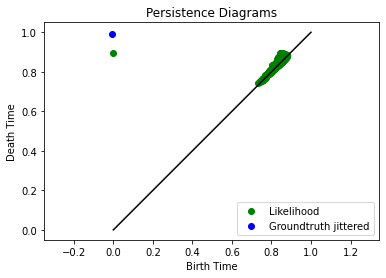

In [31]:
lh = batch_pred[4].squeeze(0)
gt = batch[1][4].squeeze(0)
lh_dgm, _, _ = compute_persistence_2DImg_1DHom_lh(lh)
gt_dgm, _, _ = compute_persistence_2DImg_1DHom_gt(gt)
draw_pers_dgms(lh_dgm, gt_dgm)

Понятно, что зеленые точки, близкие к диагонали, являются шумом. Остальные соответствуют сегментированным областям.

Начнем обучение:

In [32]:
model_topo = SegNet().to(device)
optimizer = torch.optim.AdamW(model_topo.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model_topo.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
model_topo, hist = topo_train(
    model_topo, train_loader, val_loader, bce_loss, iou_pytorch, optimizer, scheduler, num_epochs=30
)

Epoch 0/29 (lr=1.00E-03)
-------------------------
epoch:  0 BATCH:  0 lamda:  0.01
loss_total: 0.8309 loss_ce: 0.7701 topoLoss: 438.2958
$$$$$$$$$$$$$$$$$$$$$$$$
epoch:  0 BATCH:  1 lamda:  0.01
loss_total: 0.6666 loss_ce: 0.6436 topoLoss: 9.9685
$$$$$$$$$$$$$$$$$$$$$$$$
epoch:  0 BATCH:  2 lamda:  0.01
loss_total: 0.6640 loss_ce: 0.6570 topoLoss: 2.0128
$$$$$$$$$$$$$$$$$$$$$$$$
epoch:  0 BATCH:  3 lamda:  0.01
loss_total: 0.6544 loss_ce: 0.6531 topoLoss: 1.1402
$$$$$$$$$$$$$$$$$$$$$$$$
train Loss (no topo): 4.1443 Acc: 0.1630
val Loss (no topo): 3.6891 Acc: 0.1660

Epoch 1/29 (lr=1.00E-03)
-------------------------
epoch:  1 BATCH:  0 lamda:  0.01
loss_total: 0.6518 loss_ce: 0.6548 topoLoss: 0.7408
$$$$$$$$$$$$$$$$$$$$$$$$
epoch:  1 BATCH:  1 lamda:  0.01
loss_total: 0.6525 loss_ce: 0.6621 topoLoss: 0.3834
$$$$$$$$$$$$$$$$$$$$$$$$
epoch:  1 BATCH:  2 lamda:  0.01
loss_total: 0.6351 loss_ce: 0.6510 topoLoss: 0.2044
$$$$$$$$$$$$$$$$$$$$$$$$
epoch:  1 BATCH:  3 lamda:  0.01
loss_total: 

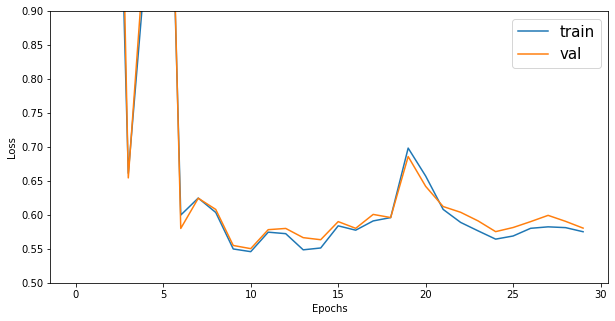

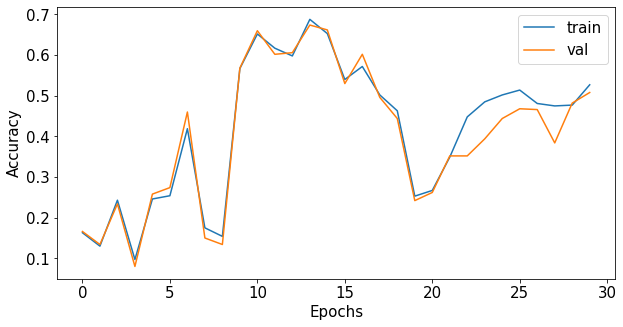

In [33]:
loss, acc, val_loss, val_acc = zip(*hist)

plt.figure(figsize=(10, 5))
plt.ylim([0.5, 0.9])
plt.rcParams.update({'font.size': 15})
plt.plot(loss, label="train")
plt.plot(val_loss, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.plot(acc, label="train")
plt.plot(val_acc, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [34]:
score = score_model(model_topo, iou_pytorch, test_loader)
model_stats['SegNet_IoU_TopoLoss'] = (score, hist)
print("Model score: ", score)

Model score:  0.69200000166893


## U-Net + IoU + BCEWithLogitsLoss

Представленная ниже модель не является абсолютной копией архитектуры из статьи, но все же очень на нее похожа, поэтому оставим за ней название U-Net.

In [35]:
# https://arxiv.org/pdf/1505.04597.pdf
class UNet(nn.Module):
    def __init__(self, keep_dim=True):
        super(UNet, self).__init__()
        self.keep_dim = keep_dim
        self.en0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
        )
        self.en1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
        )
        self.en2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
        )
        self.en3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
        )
        self.btl = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )
        self.dec0 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
        )

    def crop(self, enc_features, x):
        _, _, H, W = x.shape
        enc_features = torchvision.transforms.CenterCrop([H, W])(enc_features)
        return enc_features

    def forward(self, x):
        # old_size -> old_size - 184 (приблизительно, на самом деле нелинейно из-за округлений)
        x_t = nn.ReflectionPad2d((93, 93, 93, 93))(x) if self.keep_dim else x
        e0 = self.en0(x_t)
        e1 = self.en1(e0)
        e2 = self.en2(e1)
        e3 = self.en3(e2)

        btl = self.btl(e3)

        e3 = self.crop(e3, btl)
        btl = torch.cat([btl, e3], dim=1)

        d3 = self.dec3(btl)

        e2 = self.crop(e2, d3)
        d3 = torch.cat([d3, e2], dim=1)

        d2 = self.dec2(d3)

        e1 = self.crop(e1, d2)
        d2 = torch.cat([d2, e1], dim=1)

        d1 = self.dec1(d2)

        e0 = self.crop(e0, d1)
        d1 = torch.cat([d1, e0], dim=1)

        d0 = self.dec0(d1)
        d0 = self.crop(d0, x) if self.keep_dim else d0

        return d0


In [36]:
model_unet = UNet().to(device)

optimizer = torch.optim.AdamW(model_unet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
model_unet, hist = train_model(
    model_unet, dataloaders_dict, bce_loss, iou_pytorch, optimizer, scheduler
)

Epoch 0/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6773 Acc: 0.0000
val Loss: 0.7426 Acc: 0.0000

Epoch 1/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6959 Acc: 0.0000
val Loss: 0.6705 Acc: 0.0000

Epoch 2/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6698 Acc: 0.0000
val Loss: 0.6668 Acc: 0.0000

Epoch 3/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6640 Acc: 0.0000
val Loss: 0.6570 Acc: 0.0000

Epoch 4/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6499 Acc: 0.0000
val Loss: 0.6315 Acc: 0.0060

Epoch 5/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6197 Acc: 0.1350
val Loss: 0.5779 Acc: 0.1340

Epoch 6/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5683 Acc: 0.1190
val Loss: 0.4971 Acc: 0.3460

Epoch 7/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5625 Acc: 0.2200
val Loss: 0.5472 Acc: 0.0260

Epoch 8/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5606 Acc: 0.0330
val Loss: 0.5305 Acc: 

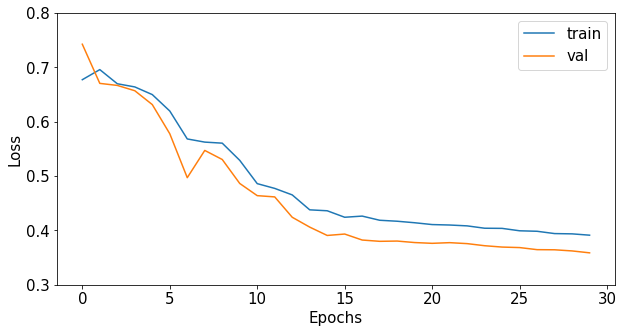

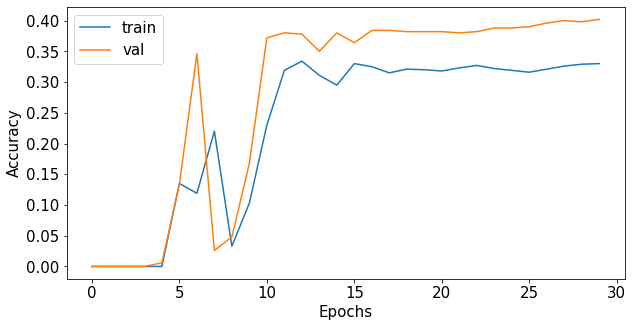

In [37]:
loss, acc, val_loss, val_acc = zip(*hist)

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.ylim([0.3, 0.8])
plt.plot(loss, label="train")
plt.plot(val_loss, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.plot(acc, label="train")
plt.plot(val_acc, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [38]:
score = score_model(model_unet, iou_pytorch, test_loader)
model_stats['UNet_IoU_BCEWithLogitsLoss'] = (score, hist)
print("Model score: ", score)

Model score:  0.346000000834465


## U-Net 2 + IoU + BCEWithLogitsLoss

In [39]:
# Просто внесены требуемые в задании изменения, какой-то общеизвестной сети под названием U-Net 2 нет
class UNet2(nn.Module):
    def __init__(self, keep_dim=True):
        super(UNet2, self).__init__()
        self.keep_dim = keep_dim
        self.en0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
        )
        self.en1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
        )
        self.en2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
        )
        self.en3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
        )
        self.btl = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
        )
        self.dec0 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
        )

    def crop(self, enc_features, x):
        _, _, H, W = x.shape
        enc_features = torchvision.transforms.CenterCrop([H, W])(enc_features)
        return enc_features

    def forward(self, x):
        # old_size -> old_size - 184 (приблизительно, на самом деле нелинейно из-за округлений)
        x_t = nn.ReflectionPad2d((93, 93, 93, 93))(x) if self.keep_dim else x
        e0 = self.en0(x_t)
        e1 = self.en1(e0)
        e2 = self.en2(e1)
        e3 = self.en3(e2)

        btl = self.btl(e3)

        e3 = self.crop(e3, btl)
        btl = torch.cat([btl, e3], dim=1)

        d3 = self.dec3(btl)

        e2 = self.crop(e2, d3)
        d3 = torch.cat([d3, e2], dim=1)

        d2 = self.dec2(d3)

        e1 = self.crop(e1, d2)
        d2 = torch.cat([d2, e1], dim=1)

        d1 = self.dec1(d2)

        e0 = self.crop(e0, d1)
        d1 = torch.cat([d1, e0], dim=1)

        d0 = self.dec0(d1)
        d0 = self.crop(d0, x) if self.keep_dim else d0

        return d0


In [40]:
model_unet2 = UNet2().to(device)

optimizer = torch.optim.AdamW(model_unet2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
model_unet2, hist = train_model(
    model_unet2, dataloaders_dict, bce_loss, iou_pytorch, optimizer, scheduler
)

Epoch 0/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6972 Acc: 0.1330
val Loss: 0.6875 Acc: 0.1220

Epoch 1/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6700 Acc: 0.0260
val Loss: 0.6222 Acc: 0.0000

Epoch 2/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6314 Acc: 0.0000
val Loss: 0.6046 Acc: 0.0000

Epoch 3/29 (lr=1.00E-03)
-------------------------
train Loss: 0.6055 Acc: 0.0000
val Loss: 0.5819 Acc: 0.0000

Epoch 4/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5813 Acc: 0.0000
val Loss: 0.5493 Acc: 0.0020

Epoch 5/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5453 Acc: 0.0810
val Loss: 0.4970 Acc: 0.2660

Epoch 6/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5025 Acc: 0.2690
val Loss: 0.4609 Acc: 0.3620

Epoch 7/29 (lr=1.00E-03)
-------------------------
train Loss: 0.5045 Acc: 0.3290
val Loss: 0.4465 Acc: 0.3760

Epoch 8/29 (lr=1.00E-03)
-------------------------
train Loss: 0.4909 Acc: 0.3150
val Loss: 0.4623 Acc: 

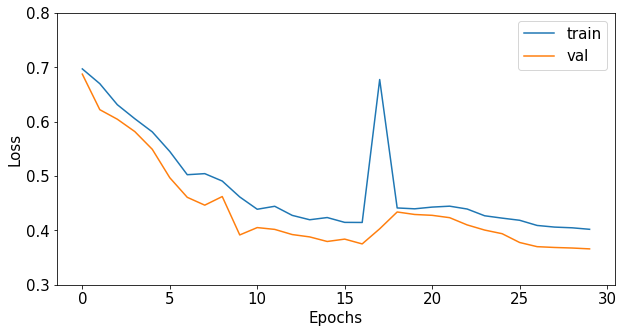

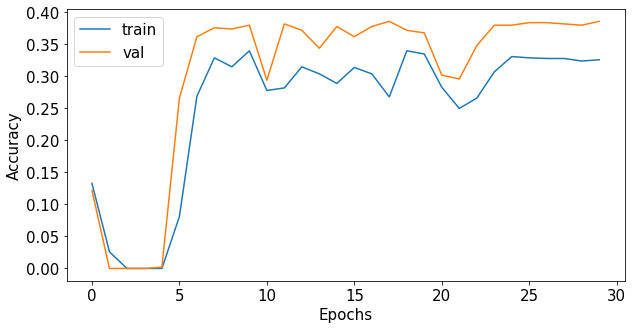

In [41]:
loss, acc, val_loss, val_acc = zip(*hist)

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.ylim([0.3, 0.8])
plt.plot(loss, label="train")
plt.plot(val_loss, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.plot(acc, label="train")
plt.plot(val_acc, label="val")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [42]:
score = score_model(model_unet2, iou_pytorch, test_loader)
model_stats['UNet2_IoU_BCEWithLogitsLoss'] = (score, hist)
print("Model score: ", score)

Model score:  0.3839999884366989


## Заключение

Посмотрим на всю полученную в процессе работы статистику:

In [43]:
df = []
for ind in range(len(loss)):
  ep = []
  for v in model_stats.values():
    loss, acc, val_loss, val_acc = zip(*v[1])
    ep += [loss[ind], acc[ind], val_loss[ind], val_acc[ind]]
  df.append(ep)

df = pd.DataFrame(df)

col_ix = pd.MultiIndex.from_product( [list(model_stats.keys()),['tr. loss', 'tr. acc', 'val. loss,', 'val. acc']]) 
row_ix = pd.MultiIndex.from_product([['Epoch'], range(len(loss))])

df = df.set_index(row_ix)
df.columns = col_ix

df

SegNet_IoU_BCEWithLogitsLoss          ... UNet2_IoU_BCEWithLogitsLoss         
                             tr. loss tr. acc  ...                  val. loss, val. acc
Epoch 0                      0.693544   0.034  ...                    0.687537    0.122
      1                      0.656269   0.062  ...                    0.622150    0.000
      2                      0.657396   0.183  ...                    0.604627    0.000
      3                      0.621403   0.273  ...                    0.581892    0.000
      4                      0.601355   0.416  ...                    0.549260    0.002
      5                      0.586769   0.455  ...                    0.496998    0.266
      6                      0.587578   0.431  ...                    0.460926    0.362
      7                      0.580121   0.541  ...                    0.446503    0.376
      8                      0.578600   0.571  ...                    0.462345    0.374
      9                      0.567853   0.612  ...                    0.391723    0.380
      10                     0.560140   0.706  ...                    0.405260    0.294
      11                     0.568449   0.647  ...                    0.401926    0.382
      12                     0.559473   0.700  ...                    0.392442    0.372
      13                     0.561174   0.670  ...                    0.388093    0.344
      14                     0.561008   0.697  ...                    0.379683    0.378
      15                     0.554368   0.738  ...                    0.384042    0.362
      16                     0.553360   0.767  ...                    0.375212    0.378
      17                     0.561308   0.679  ...                    0.402977    0.386
      18                     0.553187   0.716  ...                    0.433956    0.372
      19                     0.554011   0.736  ...                    0.429364    0.368
      20                     0.550244   0.773  ...                    0.427804    0.302
      21                     0.556503   0.728  ...                    0.423472    0.296
      22                     0.547050   0.796  ...                    0.410174    0.348
      23                     0.550981   0.759  ...                    0.400705    0.380
      24                     0.552254   0.757  ...                    0.394009    0.380
      25                     0.546206   0.815  ...                    0.377837    0.384
      26                     0.545439   0.818  ...                    0.370145    0.384
      27                     0.544065   0.832  ...                    0.368670    0.382
      28                     0.551000   0.762  ...                    0.367669    0.380
      29                     0.543913   0.829  ...                    0.366077    0.386

[30 rows x 24 columns]

Валидация всех моделей в каждой эпохе происходила посредством расчета IoU, поэтому имеет смысл как-то визуализировать эту динамику качества:

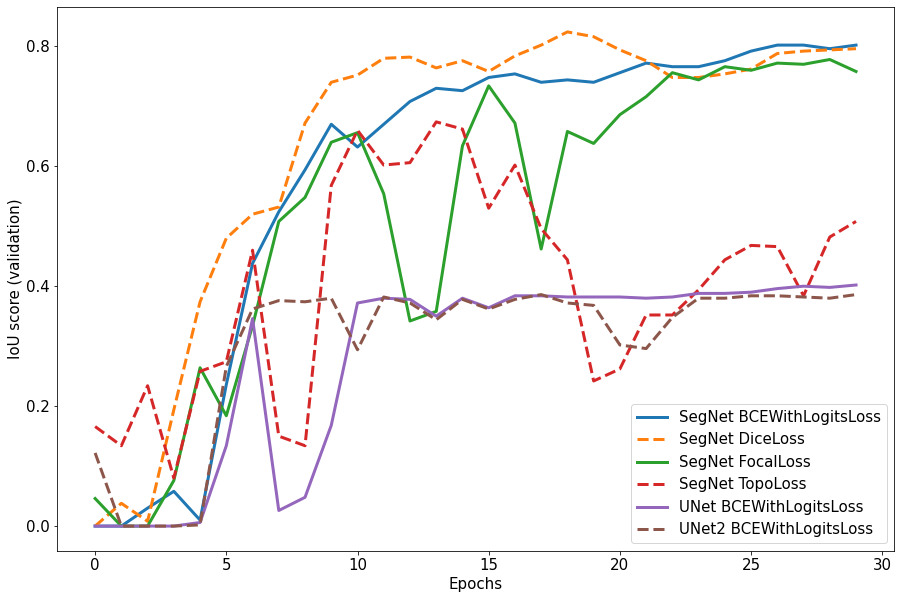

In [44]:
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 15})
linestyles = ['-', '--']
for ind, (k, v) in enumerate(model_stats.items()):
    loss, acc, val_loss, val_acc = zip(*v[1])
    plt.plot(val_acc, label=k.replace('_IoU_',' '), linewidth=3, linestyle=linestyles[ind%2])
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("IoU score (validation)")
plt.show()

Заметно, что в целом все SegNet справились лучше, чем UNet.

Предположительно это связано с тем, что UNet подходит для несколько иных (более сложных) задач, вроде сегментации клеток с узкими межклеточными расстояниями. В нашем случае кол-во пикселей разных классов в среднем довольно сбалансированно, и архитектуру подобную UNet-у не возбраняется назвать излишне сложной, т.е. склонной выделять и сохранять много бесполезной информации из по своей сути простых изображений. 

Можно считать, что разницы в поведении во время обучения и выдаваемом качестве между UNet1 и UNet2 почти нет, особенно если учесть случайные процессы (зеркальные отражения изображений, перемешка и т.п.). Иными словами, эти модели эквивалентны друг другу, по крайней мере в рамках проведенных экспериментов.

Что касается SegNet образцов, то в целом у каждого из них результаты отличные. 
BCEWithLogits/DiceLoss/FocalLoss на разных итерациях запуска ноутбука перегоняли друг друга по выдаваемому качеству, что в делает их равноценными в нашей задаче. Сходились они примерно с одинаковой скоростью, но стоит подметить, что в случае FocalLoss чаще наблюдались флуктуации с большой амплитудой.
Однако лучшей с точки зрения здравого смысла все же будет SegNet BCEWithLogits, просто потому что ее проще реализовать чем все остальное: имеется готовая (C++ compiled) Loss функция прямо в pytorch, быстрая и эффективная. 

С другой стороны DiceLoss и FocalLoss теоретически способны неплохо справляться с дисбалансом классов пикселей, делая SegNet более гибкой и в какой-то мере подводя ее к тому, на что изначально нацелен UNet.

Наконец, TopoLoss. Этот функционал ошибки интересен тем, что заставляет предсказания модели полностью повторять топологическую структуру истинного ответа. При наличии сложных изображений его применение было бы оправданным, особенно на завершающих штрихах в обучении модели, однако в работе с тем, что имеется у нас, его преимущества никак не проявляются. Применяя TopoLoss с самой первой эпохи, мы с высокой вероятностью обучаем модель совмещать неправильные точки диаграммы  персистентности. В то же время при применении его лишь на последних этапах обучения, мы будем получать нулевой вклад, т.к. все модели легко улавливают простую топологическую структуру (выделяется одно пятно). 
В дополнение к этому, вычислительная сложность TopoLoss велика, что делает необходимым аккуратную реализацию на чем-то более быстром, чем Python. Короче говоря, тут как и с UNet, вся красота может проявиться в других задачах и при более продуманной реализации.

Посмотрим максимальный IoU score каждой модели на валидационной выборке:


In [45]:
df.xs('val. acc', level=1, axis=1).max()

SegNet_IoU_BCEWithLogitsLoss    0.802
SegNet_IoU_DiceLoss             0.824
SegNet_IoU_FocalLoss            0.778
SegNet_IoU_TopoLoss             0.674
UNet_IoU_BCEWithLogitsLoss      0.402
UNet2_IoU_BCEWithLogitsLoss     0.386
dtype: float64

Стоит учесть, что указанный здесь IoU score рассчитывается с учетом порога 0.5, т.е. если, например, качество оказалось равно 0.7, то в обычном смысле (без порога) это соответствует 0.5 + 0.5 * 0.7 = 0.85

Теперь оценим результаты моделей на тестовой части:

In [46]:
for k, v in model_stats.items():
  print("{:35s}{:.4f}".format(k, v[0]))

SegNet_IoU_BCEWithLogitsLoss       0.8060
SegNet_IoU_DiceLoss                0.8060
SegNet_IoU_FocalLoss               0.7580
SegNet_IoU_TopoLoss                0.6920
UNet_IoU_BCEWithLogitsLoss         0.3460
UNet2_IoU_BCEWithLogitsLoss        0.3840


Формально (по совокупности данных из двух таблиц) побеждает SegNet_IoU_DiceLoss, но, по указанным выше причинам, самая простая модель (SegNet_IoU_BCEWithLogitsLoss) остается наиболее оптимальным с точки зрения баланса между затраченным на имплементацию временем и выдаваемым качеством выбором.